# CS 3110/5110: Data Privacy
## In-Class Exercise, week of 11/11/2024

In [7]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs3110-data-privacy/raw/main/homework/adult_with_pii.csv')

## Question 1

Implement `age_hist`, which returns a differentially private histogram of ages for ages 0-100 in the `adult` dataset.

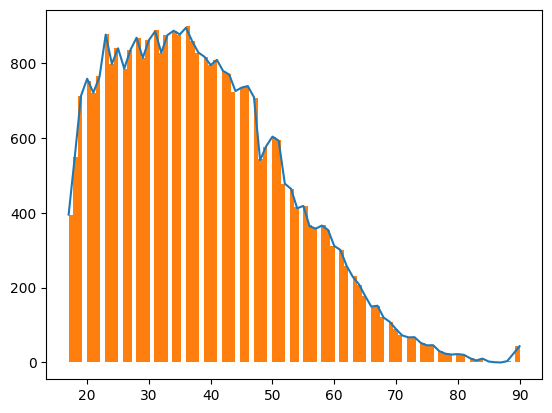

In [8]:
def age_hist(epsilon):
    hist = adult['Age'].value_counts()
    # Sensitivity = 1 because histograms are counting queries
    # Parallel composition applies because it's a histogram.
    return hist.apply(lambda x: laplace_mech(x, 1, epsilon))

plt.plot(age_hist(1.0).sort_index());
plt.hist(adult['Age'], bins=100);

## Question 2

Using the *synthetic representation* of the differentially private histogram from question 1, answer the range query, "how many people are between the ages of 30 and 42?"

In [9]:
# as the range gets bigger, tbe synthetic rep answer gets less accurate
# (The absolute error gets bigger.)
def range_query_synth(syn_rep, a, b):
    total = 0
    for i in range(a, b):
        total += syn_rep[i]
    return total

def between_30_42_syn(epsilon):
    syn_rep = age_hist(epsilon)
    return range_query_synth(syn_rep, 30, 42)
    
print('Synthetic answer:', between_30_42_syn(1.0))
print('True answer:', len(adult[(adult['Age'] >= 30) & (adult['Age'] < 42)]))

Synthetic answer: 10209.166758756852
True answer: 10215


## Question 3

Using the synthetic representation generated by the `age_hist` function, derive a differentially private approximation of the *one-way marginal* for the `Age` column of the `adult` dataset.

In [10]:
def age_marginal(epsilon):
    # A histogram is just probability distravution that doesn't add up to 1.
    # (Also no negative probabilities)
    syn_rep = age_hist(epsilon)
    syn_rep_nonzero = syn_rep.clip(lower=0)
    syn_normalized = syn_rep_nonzero / syn_rep_nonzero.sum()
    return syn_normalized.to_frame(name='probability').reset_index()


marginal = age_marginal(1.0)
print('Sum of marginal probabilities:', np.sum(marginal['probability']))
marginal

Sum of marginal probabilities: 1.0


,index,probability
0,36,0.027612
1,31,0.027266
2,34,0.027245
3,23,0.026917
4,35,0.026924
...,...,...
68,83,0.000181
69,88,0.000082
70,85,0.000111
71,86,0.000057


## Question 4

Using the marginal constructed by `age_marginal`, sample *synthetic ages* from the probability distribution it represents.

In [11]:
def gen_samples(n, marginal):
    return marginal.sample(n=n, replace=True, weights='Probability')

marginal = age_marginal(1.0)
syn_data = pd.DataFrame(gen_samples(5, marginal), columns=['Age'])
syn_data

KeyError: 'String passed to weights not a valid column'

In [ ]:
syn_data = pd.DataFrame(gen_samples(len(adult), marginal), columns=['Age'])
syn_data.hist(bins=100)
adult['Age'].hist(alpha=0.7, bins = 100);

## Accuracy of Synthetic Representation

In [ ]:
epsilon = 1.0
syn_rep = age_hist(epsilon)

# Query 1: count with 40 <= age < 43
true_answer = len(adult[(adult['Age'] >= 40) & (adult['Age'] < 43)])
print('Q1 percent error, synthetic representation:', 
      pct_error(true_answer, range_query_synth(syn_rep, 40, 43)))

lap_answer = laplace_mech(true_answer, 1, epsilon)
print('Q1 percent error, Laplace mechanism:', 
      pct_error(true_answer, lap_answer))

In [ ]:
# Query 2: count with 25 <= age < 53
true_answer = len(adult[(adult['Age'] >= 25) & (adult['Age'] < 53)])
print('Q2 percent error, synthetic representation:', 
      pct_error(true_answer, range_query_synth(syn_rep, 25, 53)))

lap_answer = laplace_mech(true_answer, 1, epsilon)
print('Q2 percent error, Laplace mechanism:', 
      pct_error(true_answer, lap_answer))

## Question 5

Which approach gives more accurate answers: the Laplace mechanism or the synthetic representation? Under what conditions is the synthetic representation good, and under what conditions is it not as good?

YOUR ANSWER HERE

## Question 6

Implement a synthetic representation for *two dimensions*: `Age` and `Occupation`.

In [ ]:
def age_occupation_hist(epsilon):
    # YOUR CODE HERE
    raise NotImplementedError()

age_occupation_hist(1.0)

## Question 7

Using the synthetic representation from Question 6, implement functions to calculate the *two-way marginal distribution* and generate synthetic data samples.

In [ ]:
def age_occupation_marginal(epsilon):
    # YOUR CODE HERE
    raise NotImplementedError()

def gen_samples(n, marginal):
    # YOUR CODE HERE
    raise NotImplementedError()

marginal = age_occupation_marginal(1.0)
gen_samples(15, marginal)

## Question 8

Generate synthetic data for the Age and Occupation columns by using a two-way marginal as a *conditional distribution*. Use `age_marginal` to generate data for the Age column, then use `age_occupation_marginal` to generate the Occupation column by *conditioning* on the Age column.

In [ ]:
def gen_age_occupation_conditional(n, epsilon):
    # YOUR CODE HERE
    raise NotImplementedError()

gen_age_occupation_conditional(15, 1.0)